In [1]:
import os
import pickle
import pandas as pd
import json
import sys
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Switch to parent path to import local module
parent_path = str(os.getcwd()).split('notebooks')[0] # zeosyn_gen
os.chdir(parent_path)
print('Switched directory to:', os.getcwd())

from eval import get_metric_dataframes, get_prediction_and_ground_truths, eval_single_system
import data.utils as utils
sys.modules['utils'] = utils # Way to get around relative imports in utils for ZeoSynGen_dataset # https://stackoverflow.com/questions/2121874/python-pickling-after-changing-a-modules-directory
from models.diffusion import *

/home/synthesisproject/anaconda3/envs/zeo_diffusion_metrics/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


Switched directory to: /home/jupyter/Elton/Zeolites/zeosyn_gen


/home/synthesisproject/anaconda3/envs/zeo_diffusion_metrics/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Load diffusion model
model_type = 'diff'
split = 'system'
fname = 'v3'
with open(f'runs/{model_type}/{split}/{fname}/configs.json') as f:
    configs_diff = json.load(f)

# Load CVAE model
model_type = 'cvae'
split = 'system'
fname = 'v10'
with open(f'runs/{model_type}/{split}/{fname}/configs.json') as f:
    configs_cvae = json.load(f)

syn_pred_diff, syn_pred_scaled_diff, syn_true_diff, syn_true_scaled_diff, _ = get_prediction_and_ground_truths(_, configs_diff, cond_scale=1)
syn_pred_cvae, syn_pred_scaled_cvae, syn_true_cvae, syn_true_scaled_cvae, dataset = get_prediction_and_ground_truths(_, configs_cvae)

mmd_zeo_agg_df_diff, wsd_zeo_agg_df_diff, mmd_zeo_osda_df_diff, wsd_zeo_osda_df_diff = get_metric_dataframes(configs_diff)
mmd_zeo_agg_df_cvae, wsd_zeo_agg_df_cvae, mmd_zeo_osda_df_cvae, wsd_zeo_osda_df_cvae = get_metric_dataframes(configs_cvae)

Getting model predictions and grouth truths...
SYSTEMS:
train+val: 1856 test: 464

n_datapoints:
train: 14749 val: 2107 test: 5168
Loading synthetic predictions from saved predictions...
Getting model predictions and grouth truths...
SYSTEMS:
train+val: 1856 test: 464

n_datapoints:
train: 14749 val: 2107 test: 5168
Loading synthetic predictions from saved predictions...


# Metrics in decreasing frequency in test set

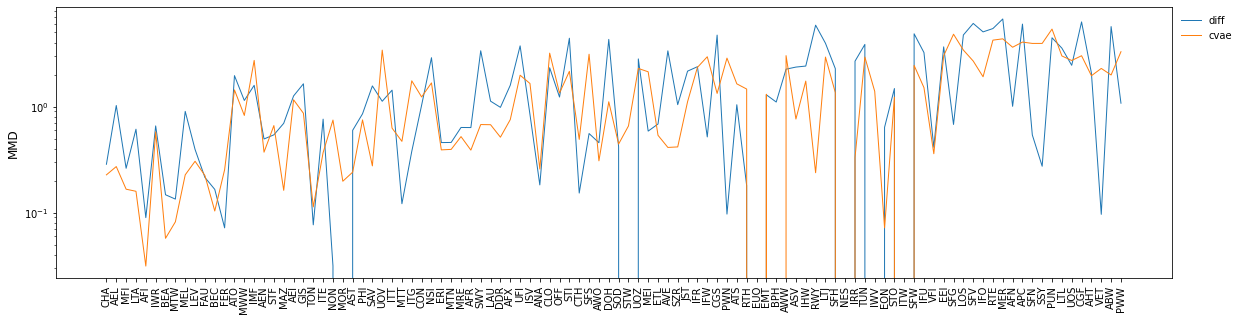

In [3]:
plt.figure(figsize=(20, 5))
plt.plot(mmd_zeo_agg_df_diff['zeo'], mmd_zeo_agg_df_diff['MMD'], label='diff')
plt.plot(mmd_zeo_agg_df_cvae['zeo'], mmd_zeo_agg_df_cvae['MMD'], label='cvae')
plt.ylabel('MMD')
plt.xticks(rotation=90)
plt.yscale('log')
plt.legend()
plt.show()

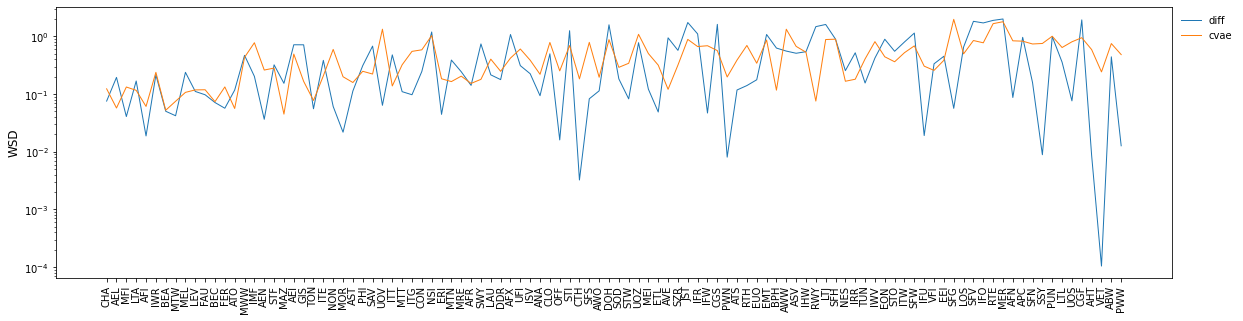

In [4]:
plt.figure(figsize=(20, 5))
plt.plot(wsd_zeo_agg_df_diff['zeo'], wsd_zeo_agg_df_diff['WSD'], label='diff')
plt.plot(wsd_zeo_agg_df_cvae['zeo'], wsd_zeo_agg_df_cvae['WSD'], label='cvae')
plt.ylabel('WSD')
plt.xticks(rotation=90)
plt.yscale('log')
plt.legend()
plt.show()

MMD diff: 0.1655921936035156
WSD diff: 0.0713865216808757

MMD cvae: 0.1035661697387695
WSD cvae: 0.0739224324042668


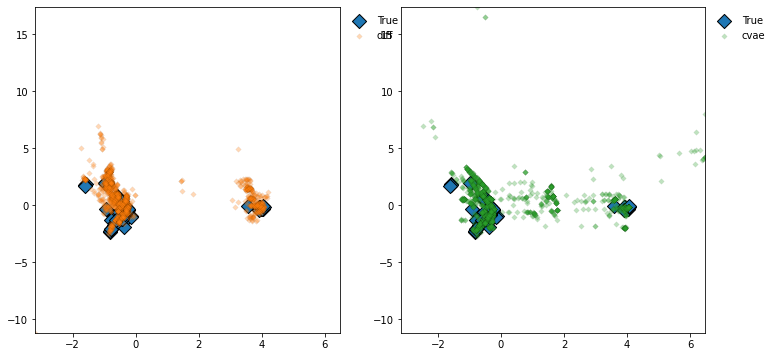

In [5]:
def compare_side_by_side(syn_pred1, syn_pred_scaled1, syn_pred2, syn_pred_scaled2, syn_true, syn_true_scaled, dataset, mmd_zeo_agg_df1, wsd_zeo_agg_df1, mmd_zeo_osda_df1, wsd_zeo_osda_df1, mmd_zeo_agg_df2, wsd_zeo_agg_df2, mmd_zeo_osda_df2, wsd_zeo_osda_df2, zeo, osda=None, plot=True, print_metrics=True, pca=False):
    
    if osda == None: # Zeolite-aggregated
        if plot:
            print(f'====== ZEO: {zeo} ======')

        sys_syn_true = syn_true[syn_true['zeo'] == zeo]
        sys_syn_true_scaled = syn_true_scaled[syn_true_scaled['zeo'] == zeo]

        sys_syn_pred1 = syn_pred1[syn_pred1['zeo'] == zeo]
        sys_syn_pred2 = syn_pred2[syn_pred2['zeo'] == zeo]

        sys_syn_pred_scaled1 = syn_pred_scaled1[syn_pred_scaled1['zeo'] == zeo]
        sys_syn_pred_scaled2 = syn_pred_scaled2[syn_pred_scaled2['zeo'] == zeo]

        if print_metrics:
            mmd1 = mmd_zeo_agg_df1[mmd_zeo_agg_df1['zeo']==zeo]['MMD'].item()
            mmd2 = mmd_zeo_agg_df2[mmd_zeo_agg_df2['zeo']==zeo]['MMD'].item()
            wsd1 = wsd_zeo_agg_df1[wsd_zeo_agg_df1['zeo']==zeo]['WSD'].item()
            wsd2 = wsd_zeo_agg_df2[wsd_zeo_agg_df2['zeo']==zeo]['WSD'].item()

            print('MMD diff:', mmd1)
            print('WSD diff:', wsd1)
            print()
            print('MMD cvae:', mmd2)
            print('WSD cvae:', wsd2)

    else: # Zeolite-OSDA
        if plot:
            print(f'====== ZEO: {zeo} OSDA: {osda} ======')

        sys_syn_true = syn_true[(syn_true['zeo'] == zeo) & (syn_true['osda'] == osda)]
        sys_syn_true_scaled = syn_true_scaled[(syn_true_scaled['zeo'] == zeo) & (syn_true_scaled['osda'] == osda)]

        sys_syn_pred1 = syn_pred1[(syn_pred1['zeo'] == zeo) & (syn_pred1['osda'] == osda)]
        sys_syn_pred2 = syn_pred2[(syn_pred2['zeo'] == zeo) & (syn_pred2['osda'] == osda)]

        sys_syn_pred_scaled1 = syn_pred_scaled1[(syn_pred_scaled1['zeo'] == zeo) & (syn_pred_scaled1['osda'] == osda)]
        sys_syn_pred_scaled2 = syn_pred_scaled2[(syn_pred_scaled2['zeo'] == zeo) & (syn_pred_scaled2['osda'] == osda)]

        if print_metrics:
            mmd1 = mmd_zeo_osda_df1[(mmd_zeo_osda_df1['zeo']==zeo) & (mmd_zeo_osda_df1['osda']==osda)]['MMD'].item()
            mmd2 = mmd_zeo_osda_df2[(mmd_zeo_osda_df2['zeo']==zeo) & (mmd_zeo_osda_df2['osda']==osda)]['MMD'].item()
            wsd1 = wsd_zeo_osda_df1[(wsd_zeo_osda_df1['zeo']==zeo) & (wsd_zeo_osda_df1['osda']==osda)]['WSD'].item()
            wsd2 = wsd_zeo_osda_df2[(wsd_zeo_osda_df2['zeo']==zeo) & (wsd_zeo_osda_df2['osda']==osda)]['WSD'].item()

            print('MMD diff:', mmd1)
            print('WSD diff:', wsd1)
            print()
            print('MMD cvae:', mmd2)
            print('WSD cvae:', wsd2)

    if plot:
        utils.compare_gel_conds([sys_syn_pred1, sys_syn_pred2, sys_syn_true], ['diff', 'cvae', 'True'], [True, True, False], [False, False, True], ['tab:orange', 'tab:green', 'tab:blue'], common_norm=True, alpha=0.35)
    
    if pca:
        combined_df = pd.concat([sys_syn_pred1, sys_syn_pred2, sys_syn_true])
        combined_df['origin'] = ['diff']*len(sys_syn_pred1) + ['cvae']*len(sys_syn_pred2) + ['True']*len(sys_syn_true)
        X = combined_df[dataset.ratio_names+dataset.cond_names].values
        scaler = StandardScaler()
        X = scaler.fit_transform(X)
        pca = PCA(n_components=2)
        X_pca = pca.fit_transform(X)
        X_pca = pd.DataFrame({'PC1': X_pca[:, 0], 'PC2': X_pca[:, 1], 'origin': combined_df['origin']})
        
        sys_syn_pred_pca1 = X_pca[X_pca['origin'] == 'diff']
        sys_syn_pred_pca2 = X_pca[X_pca['origin'] == 'cvae']
        sys_syn_true_pca = X_pca[X_pca['origin'] == 'True']

        fig = plt.figure(figsize=(12, 6))

        ax1 = fig.add_subplot(1, 2, 1)
        ax1.scatter(sys_syn_true_pca['PC1'], sys_syn_true_pca['PC2'], label='True', color='tab:blue', alpha=1, s=100, linewidth=1, edgecolor='black')
        ax1.scatter(sys_syn_pred_pca1['PC1'], sys_syn_pred_pca1['PC2'], label='diff', color='tab:orange', alpha=0.3, linewidth=0.1, edgecolor='black')
        ax1.legend()
        ax1.set_xlim(X_pca['PC1'].min(), X_pca['PC1'].max())
        ax1.set_ylim(X_pca['PC2'].min(), X_pca['PC2'].max())
    
        ax2 = fig.add_subplot(1, 2, 2)
        ax2.scatter(sys_syn_true_pca['PC1'], sys_syn_true_pca['PC2'], label='True', color='tab:blue', alpha=1, s=100, linewidth=1, edgecolor='black')
        ax2.scatter(sys_syn_pred_pca2['PC1'], sys_syn_pred_pca2['PC2'], label='cvae', color='tab:green', alpha=0.3, linewidth=0.1, edgecolor='black')
        ax2.legend()
        ax2.set_xlim(X_pca['PC1'].min(), X_pca['PC1'].max())
        ax2.set_ylim(X_pca['PC2'].min(), X_pca['PC2'].max())
        
        plt.show()

    print()
    
compare_side_by_side(syn_pred_diff, syn_pred_scaled_diff, syn_pred_cvae, syn_pred_scaled_cvae, syn_true_diff, syn_true_scaled_diff, dataset, mmd_zeo_agg_df_diff, wsd_zeo_agg_df_diff, mmd_zeo_osda_df_diff, wsd_zeo_osda_df_diff, mmd_zeo_agg_df_cvae, wsd_zeo_agg_df_cvae, mmd_zeo_osda_df_cvae, wsd_zeo_osda_df_cvae, zeo='BEC', plot=False, pca=True)
                    # (syn_pred_cvae, syn_pred_scaled_cvae, syn_pred_diff, syn_pred_scaled_diff, syn_true_cvae, syn_true_scaled_cvae, dataset, mmd_zeo_agg_df_cvae, wsd_zeo_agg_df_cvae, mmd_zeo_osda_df_cvae, wsd_zeo_osda_df_cvae, mmd_zeo_agg_df_diff, wsd_zeo_agg_df_diff, mmd_zeo_osda_df_diff, wsd_zeo_osda_df_diff, zeo='BEC', plot=False, pca=True)

# Zeolite-aggregated

MMD diff: 0.2857265472412109
WSD diff: 0.0756486186407265

MMD cvae: 0.2270488739013672
WSD cvae: 0.1234055284623895


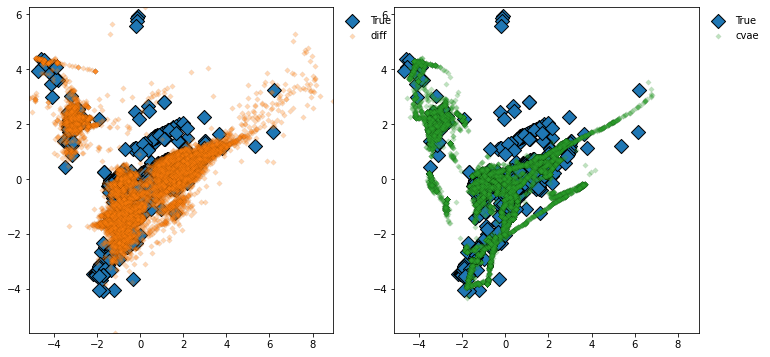


MMD diff: 1.024094581604004
WSD diff: 0.1949764153812809

MMD cvae: 0.2717819213867187
WSD cvae: 0.0573670332500681


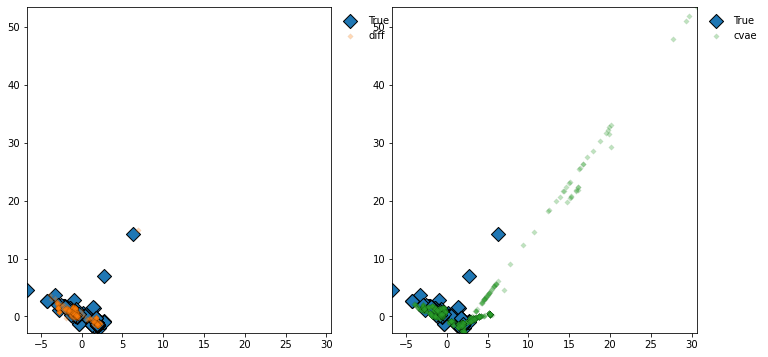


MMD diff: 0.2618770599365234
WSD diff: 0.0407763557801101

MMD cvae: 0.1663188934326172
WSD cvae: 0.1327364396861895


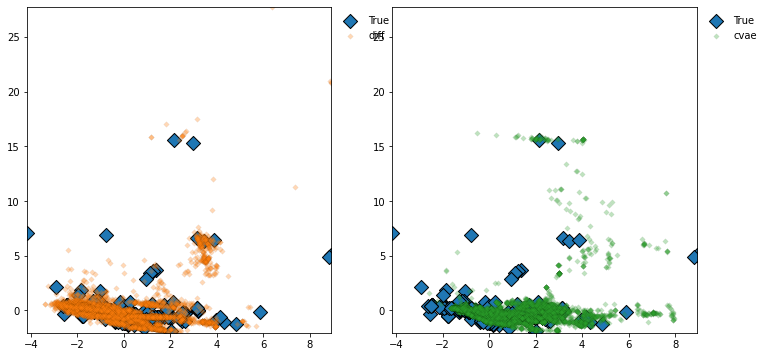


MMD diff: 0.6118278503417969
WSD diff: 0.1687553646250476

MMD cvae: 0.158881664276123
WSD cvae: 0.1161977561179953


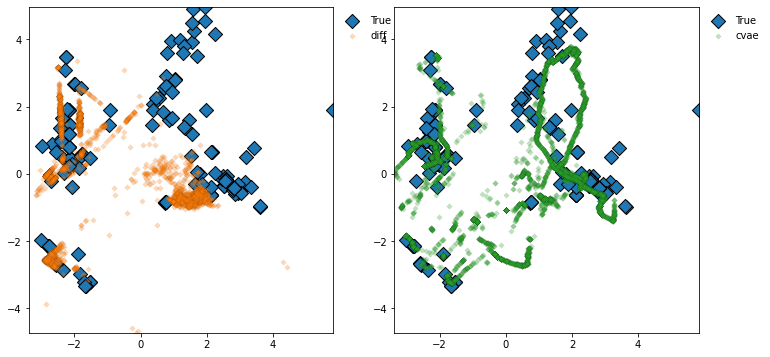


MMD diff: 0.089700698852539
WSD diff: 0.0188040298621505

MMD cvae: 0.0313119888305664
WSD cvae: 0.0611221704642627


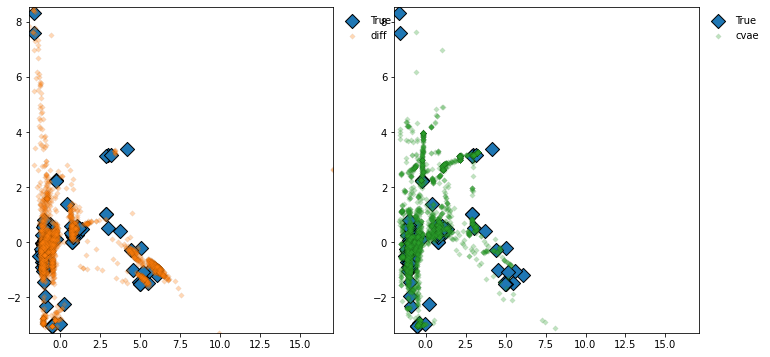


MMD diff: 0.6573219299316406
WSD diff: 0.2154577042990513

MMD cvae: 0.5780611038208008
WSD cvae: 0.2383899767663029


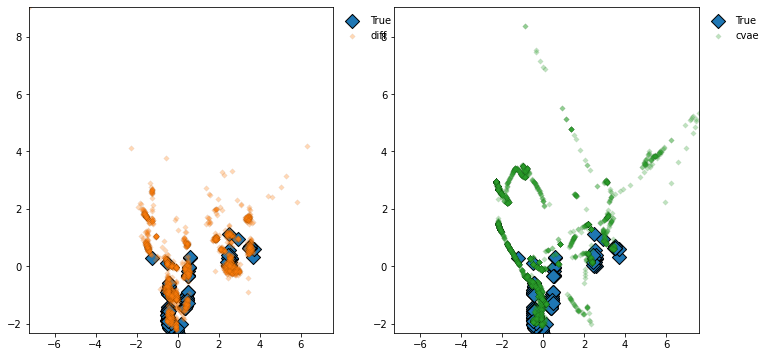


MMD diff: 0.1473798751831054
WSD diff: 0.0503472716645777

MMD cvae: 0.0572099685668945
WSD cvae: 0.052514567327067


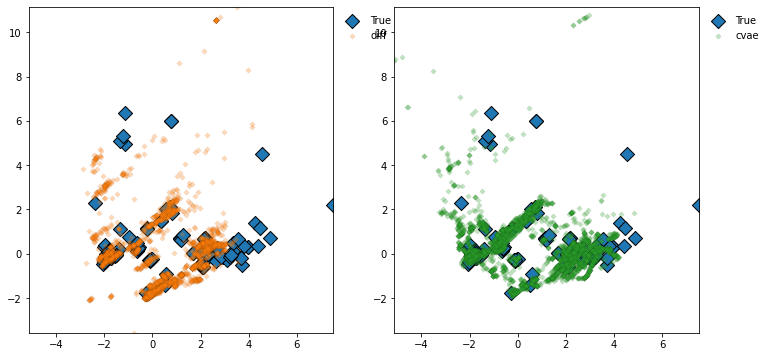


MMD diff: 0.134103775024414
WSD diff: 0.0421115417812325

MMD cvae: 0.0818071365356445
WSD cvae: 0.0750745985987606


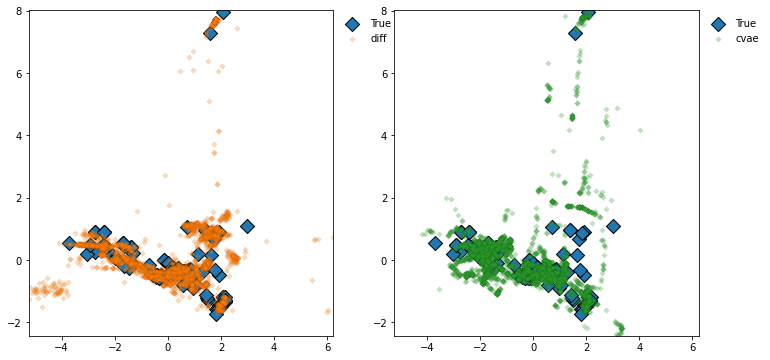


MMD diff: 0.90106201171875
WSD diff: 0.2385387237125324

MMD cvae: 0.2271022796630859
WSD cvae: 0.1071135070658056


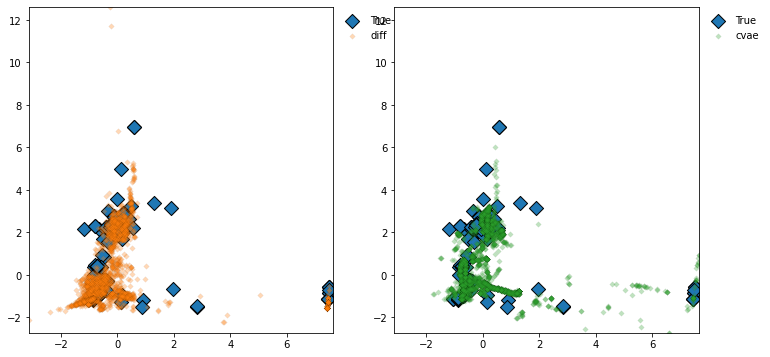


MMD diff: 0.3941364288330078
WSD diff: 0.1111352164671646

MMD cvae: 0.3050107955932617
WSD cvae: 0.1181884659228243


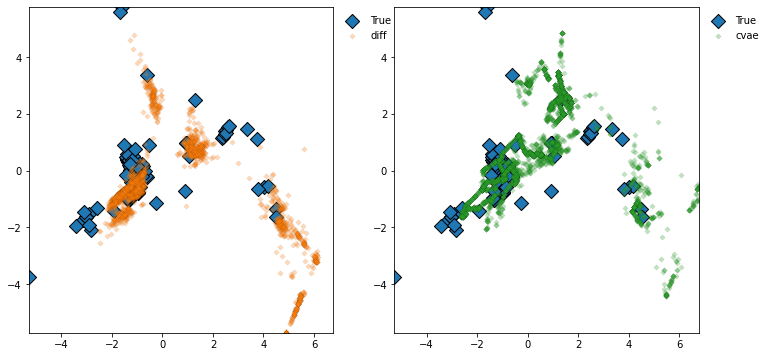


MMD diff: 0.214609146118164
WSD diff: 0.0972901070349319

MMD cvae: 0.2238664627075195
WSD cvae: 0.118881455007565


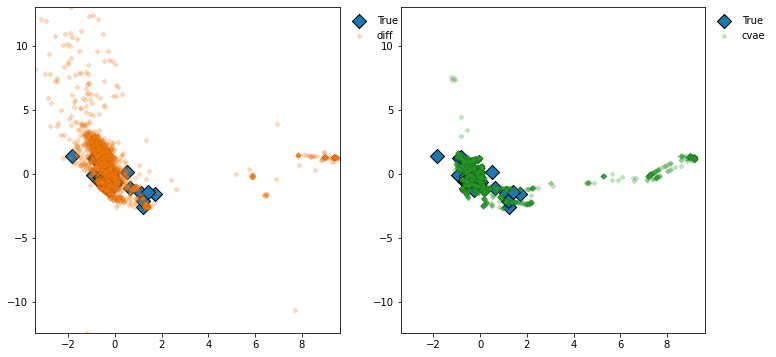


MMD diff: 0.1655921936035156
WSD diff: 0.0713865216808757

MMD cvae: 0.1035661697387695
WSD cvae: 0.0739224324042668


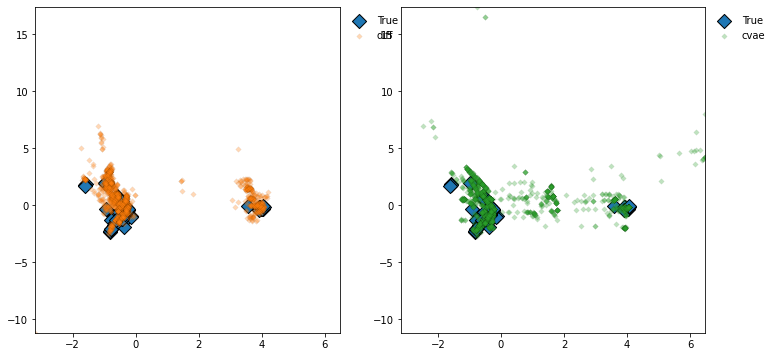


MMD diff: 0.0718097686767578
WSD diff: 0.0568490241393191

MMD cvae: 0.2538967132568359
WSD cvae: 0.1331114839215356


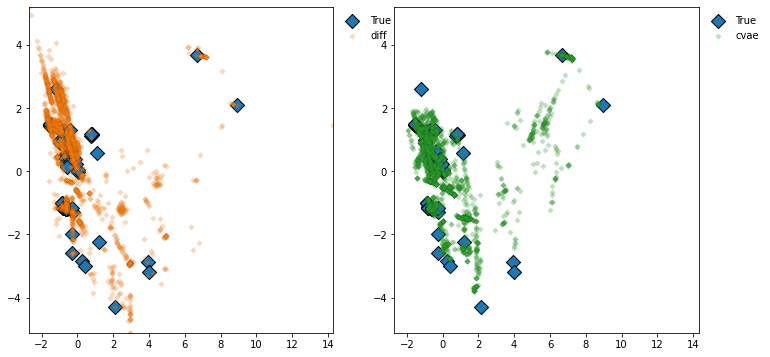


MMD diff: 1.9591455459594729
WSD diff: 0.1174971325100142

MMD cvae: 1.435647964477539
WSD cvae: 0.0562197658515655


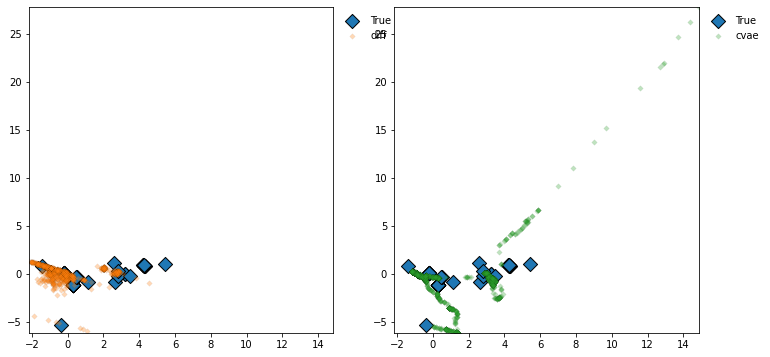


MMD diff: 1.1425704956054688
WSD diff: 0.4702345881848252

MMD cvae: 0.8251819610595703
WSD cvae: 0.4343392346340534


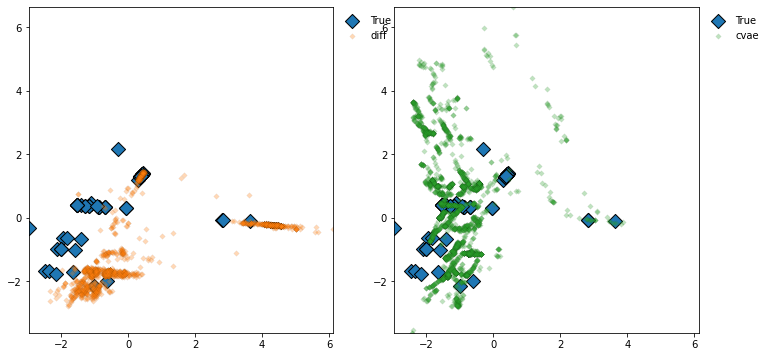


MMD diff: 1.5866022109985352
WSD diff: 0.2030510712874135

MMD cvae: 2.727296829223633
WSD cvae: 0.777560353380454


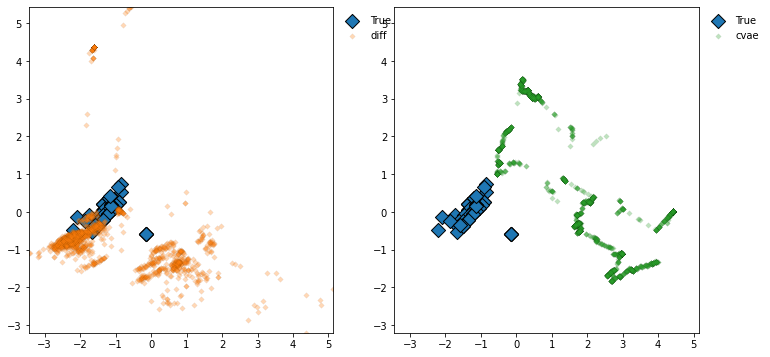


MMD diff: 0.4949760437011719
WSD diff: 0.0365561291601485

MMD cvae: 0.3715429306030273
WSD cvae: 0.2613671792041163


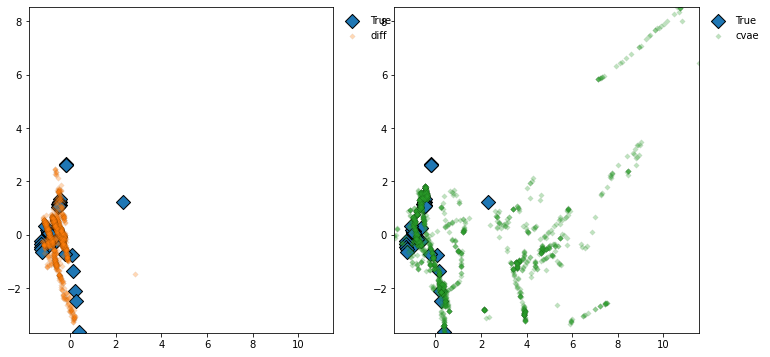


MMD diff: 0.541417121887207
WSD diff: 0.3220745623537451

MMD cvae: 0.6619930267333984
WSD cvae: 0.282571910931769


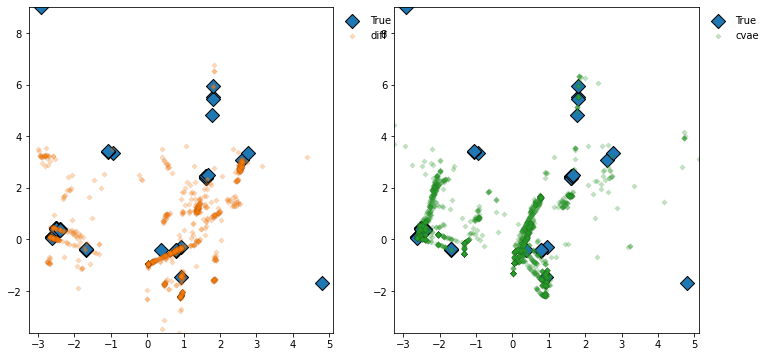


MMD diff: 0.695500373840332
WSD diff: 0.153751307853241

MMD cvae: 0.1622152328491211
WSD cvae: 0.0449400556666653


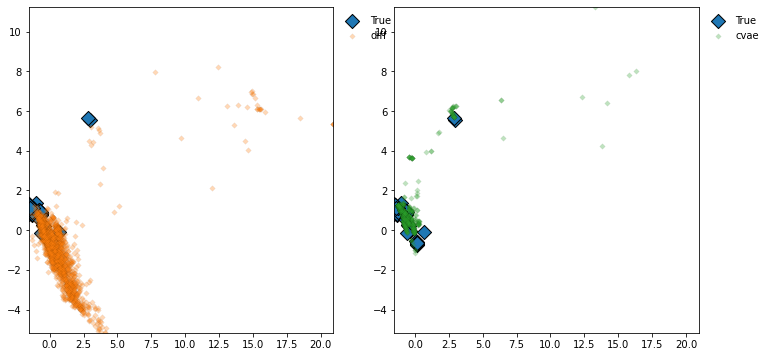


MMD diff: 1.259929656982422
WSD diff: 0.7171832528999589

MMD cvae: 1.159407615661621
WSD cvae: 0.4945250925331349


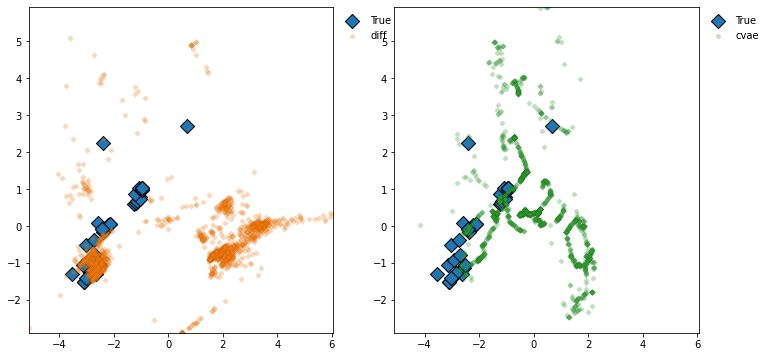


MMD diff: 1.640920639038086
WSD diff: 0.7158634270268296

MMD cvae: 0.865565299987793
WSD cvae: 0.1664825181350349


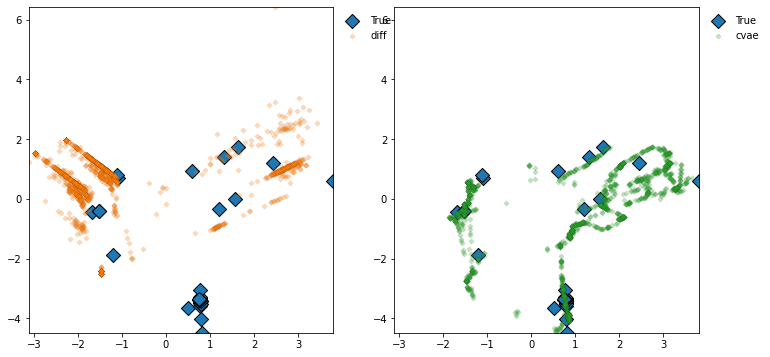


MMD diff: 0.0766773223876953
WSD diff: 0.0556567313133731

MMD cvae: 0.1132488250732421
WSD cvae: 0.0774120842886719


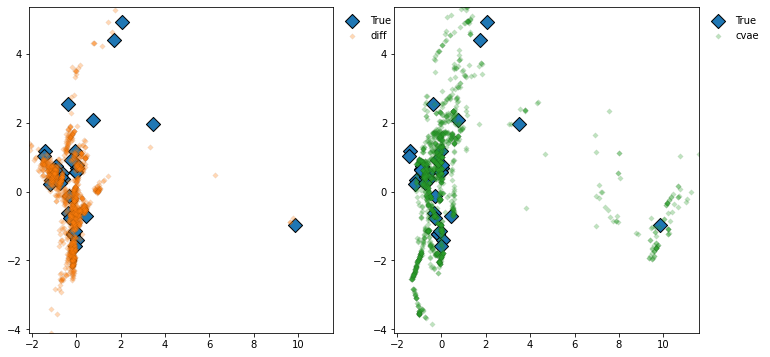


MMD diff: 0.7614049911499023
WSD diff: 0.3845785425869152

MMD cvae: 0.3687620162963867
WSD cvae: 0.2074721063537419


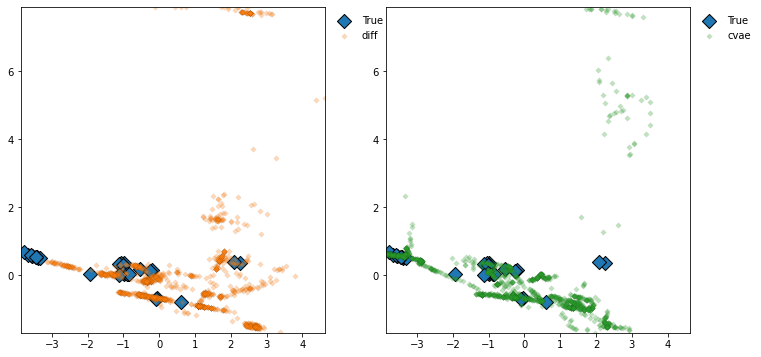


MMD diff: 0.0314064025878906
WSD diff: 0.0609882813845575

MMD cvae: 0.7463102340698242
WSD cvae: 0.5963358793600724


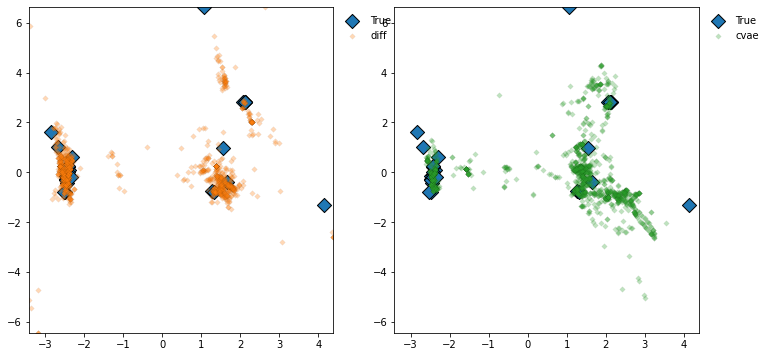


MMD diff: -0.0122833251953125
WSD diff: 0.0218065947040402

MMD cvae: 0.1976346969604492
WSD cvae: 0.1999740248545163


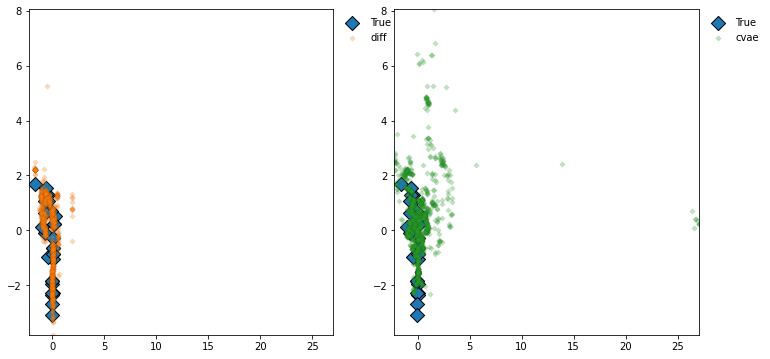


MMD diff: 0.5972204208374023
WSD diff: 0.1132035727267154

MMD cvae: 0.2407960891723632
WSD cvae: 0.1588826521415122


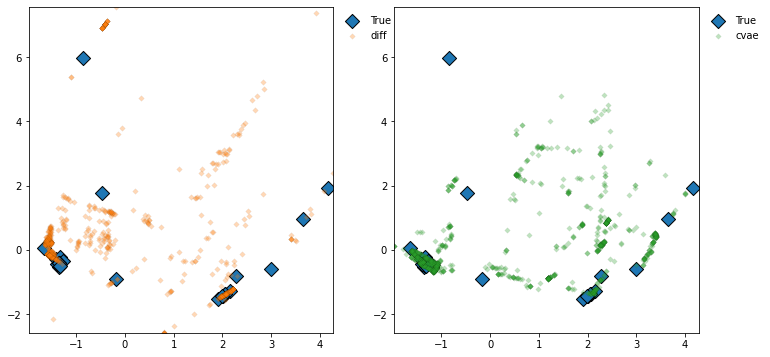


MMD diff: 0.8546304702758789
WSD diff: 0.3117513151016049

MMD cvae: 0.7490997314453125
WSD cvae: 0.2486922283073456


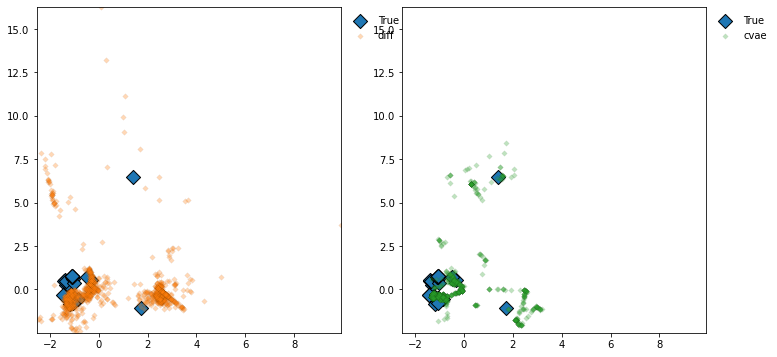


MMD diff: 1.5667343139648438
WSD diff: 0.680164003450905

MMD cvae: 0.2758541107177734
WSD cvae: 0.222753539651447


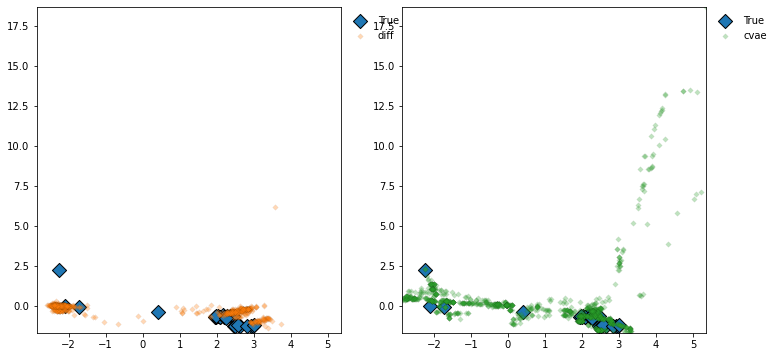


MMD diff: 1.122756004333496
WSD diff: 0.0638980686975452

MMD cvae: 3.4091925621032715
WSD cvae: 1.336136504792104


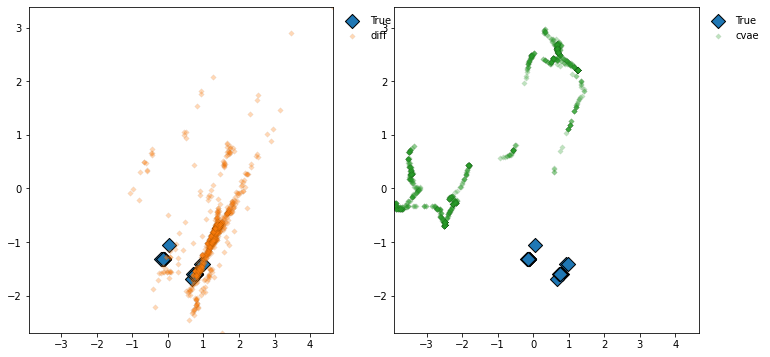


MMD diff: 1.4293522834777832
WSD diff: 0.4790074658085085

MMD cvae: 0.6265220642089844
WSD cvae: 0.1382425545418362


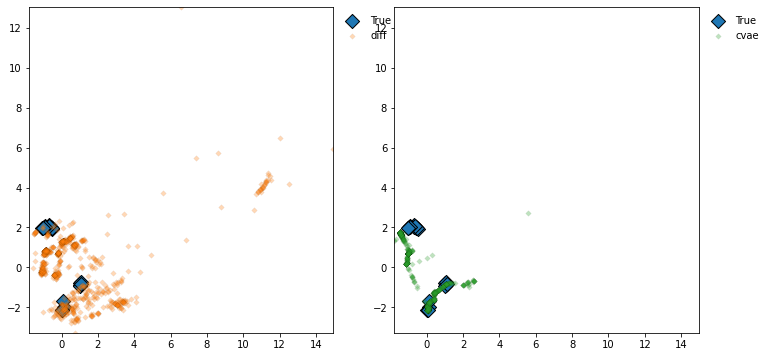

In [6]:
count = 0
for zeo in mmd_zeo_agg_df_cvae['zeo']:
    try:
        compare_side_by_side(syn_pred_diff, syn_pred_scaled_diff, syn_pred_cvae, syn_pred_scaled_cvae, syn_true_diff, syn_true_scaled_diff, dataset, mmd_zeo_agg_df_diff, wsd_zeo_agg_df_diff, mmd_zeo_osda_df_diff, wsd_zeo_osda_df_diff, mmd_zeo_agg_df_cvae, wsd_zeo_agg_df_cvae, mmd_zeo_osda_df_cvae, wsd_zeo_osda_df_cvae, zeo=zeo, plot=False, pca=True)
    except Exception as e:
        print(e)

    count += 1
    if count == 30:
        break

# Zeolite-OSDA

MMD diff: 1.231027603149414
WSD diff: 0.2815219446267359

MMD cvae: 1.6180658340454102
WSD cvae: 0.2315756006319573


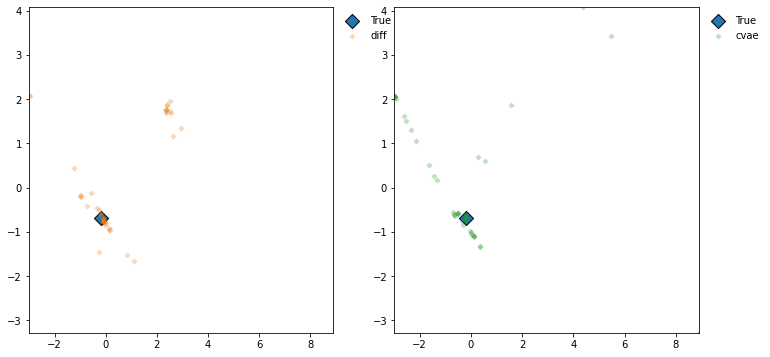


MMD diff: 1.2049932479858398
WSD diff: 0.0201396581167849

MMD cvae: 1.6850366592407229
WSD cvae: 0.376640212282774


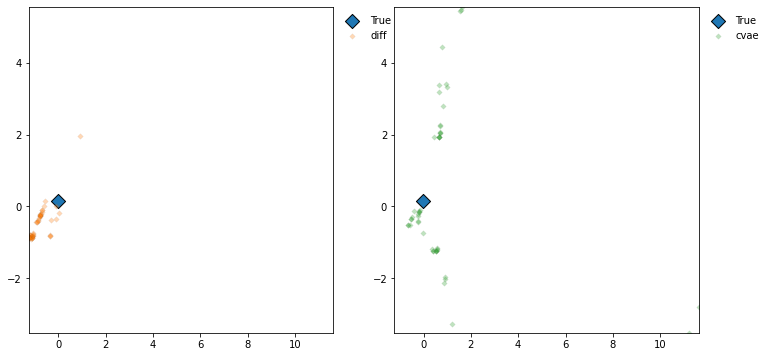


MMD diff: 6.853334426879883
WSD diff: 1.9370167244969307

MMD cvae: 1.796198844909668
WSD cvae: 0.5280352215768505


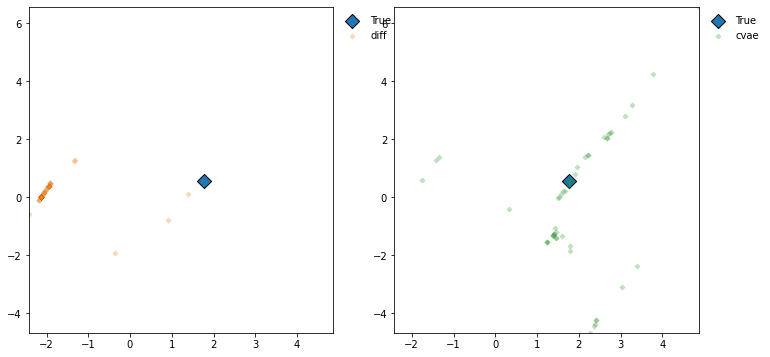


MMD diff: 5.06764554977417
WSD diff: 1.7155569772265344

MMD cvae: 1.9115886688232424
WSD cvae: 0.7758621424196508


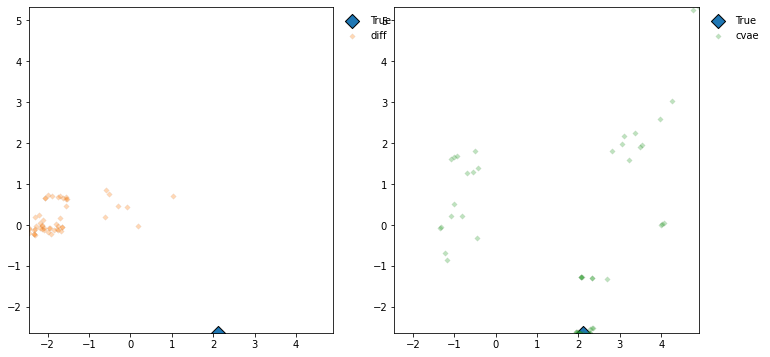


MMD diff: 2.0002593994140625
WSD diff: 0.00793271365862

MMD cvae: 2.653239250183105
WSD cvae: 0.3835653144998909


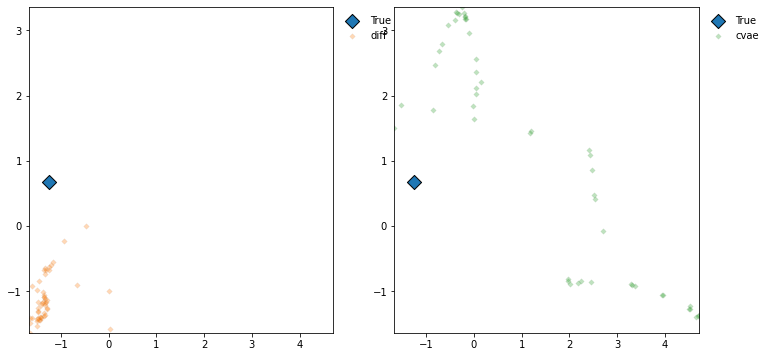


MMD diff: 3.289640426635742
WSD diff: 0.0834712012792431

MMD cvae: 3.229688167572021
WSD cvae: 0.7228709692171218


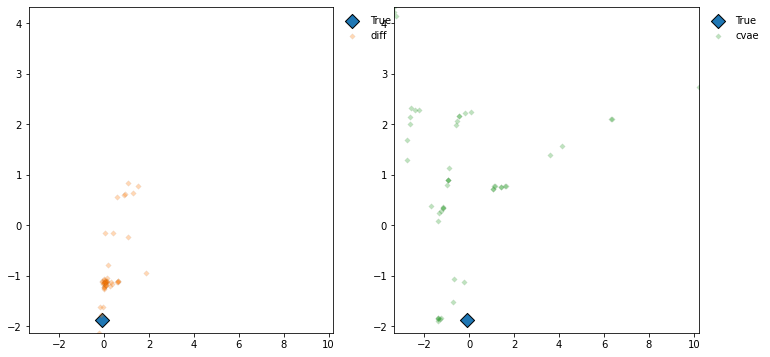


MMD diff: 0.2183742523193359
WSD diff: 0.0002207196447956

MMD cvae: 2.2504196166992188
WSD cvae: 0.3969124423020942


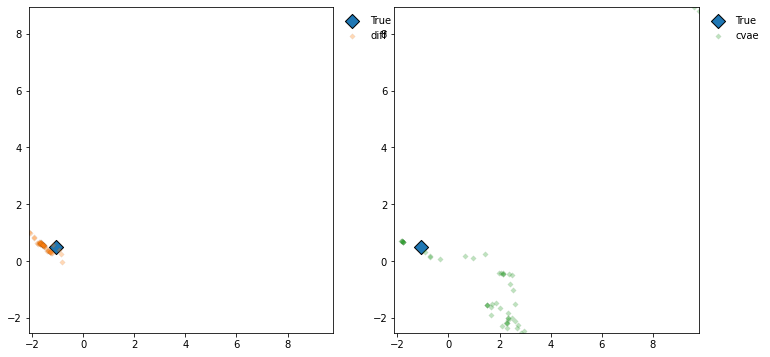


MMD diff: 2.1718244552612305
WSD diff: 0.4121432147614231

MMD cvae: 2.034149169921875
WSD cvae: 0.0961978951493989


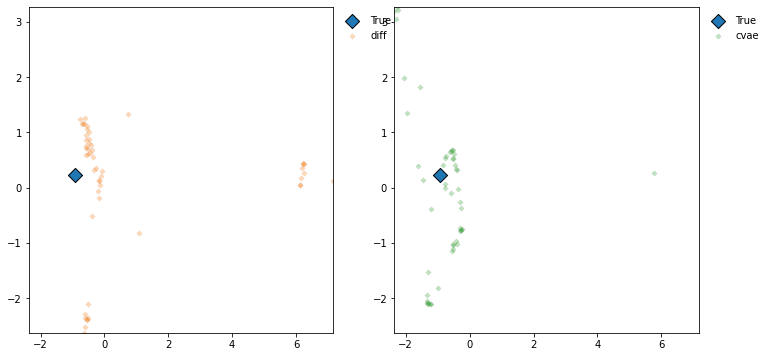


MMD diff: 0.4150524139404297
WSD diff: 0.0013712234504634

MMD cvae: 1.8331336975097656
WSD cvae: 0.1573150093567809


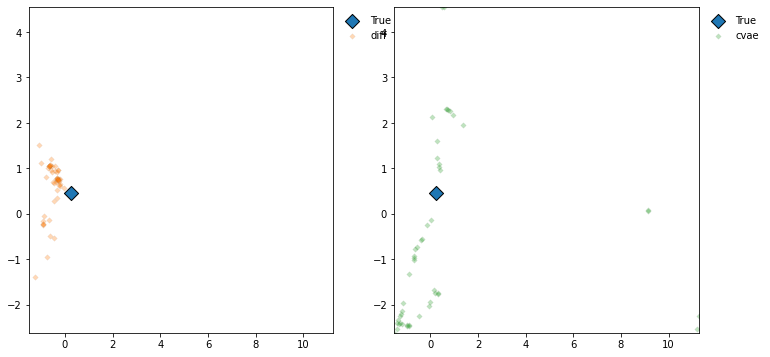


MMD diff: 2.419210433959961
WSD diff: 0.2557227809670617

MMD cvae: 2.756546974182129
WSD cvae: 0.7086853447236645


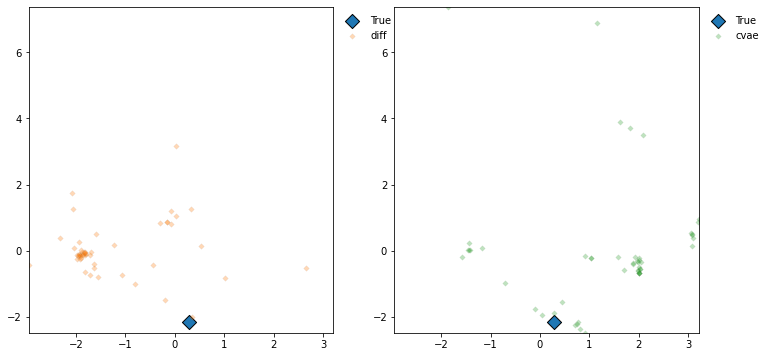


MMD diff: 1.965412139892578
WSD diff: 0.1145040262270923

MMD cvae: 1.4902629852294922
WSD cvae: 0.0072871261574093


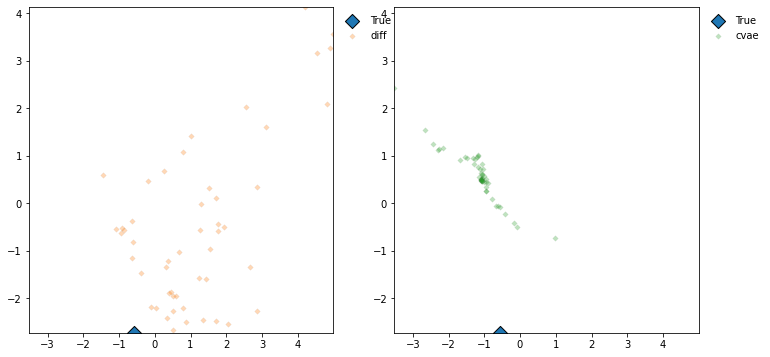


MMD diff: 4.3436279296875
WSD diff: 0.6275107346351858

MMD cvae: 3.010021209716797
WSD cvae: 0.587780798701269


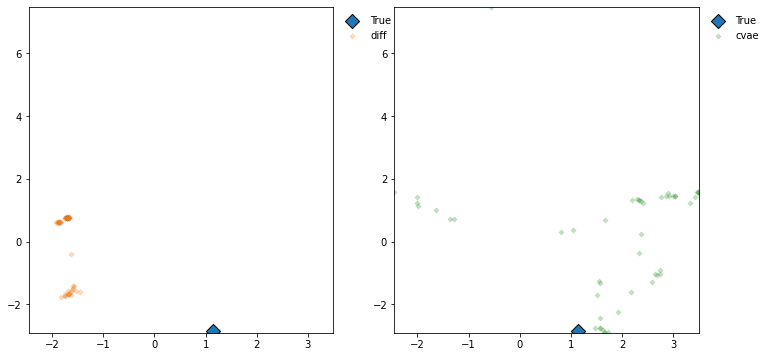


MMD diff: 0.9395217895507812
WSD diff: 0.0887750456188637

MMD cvae: 3.6031813621521
WSD cvae: 0.7491325205625755


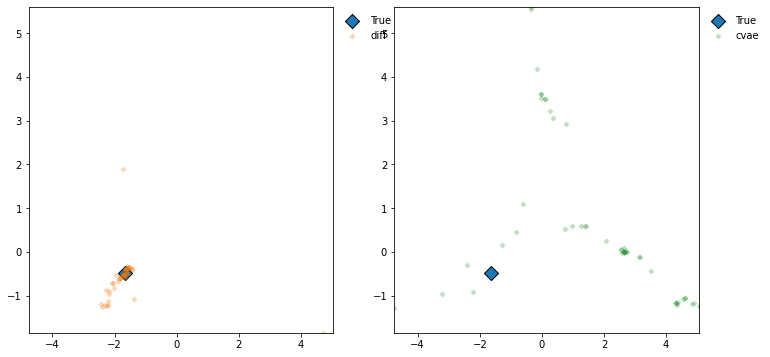


MMD diff: 1.7014617919921875
WSD diff: 0.0219596066853244

MMD cvae: 2.9213600158691406
WSD cvae: 0.5092778849898618


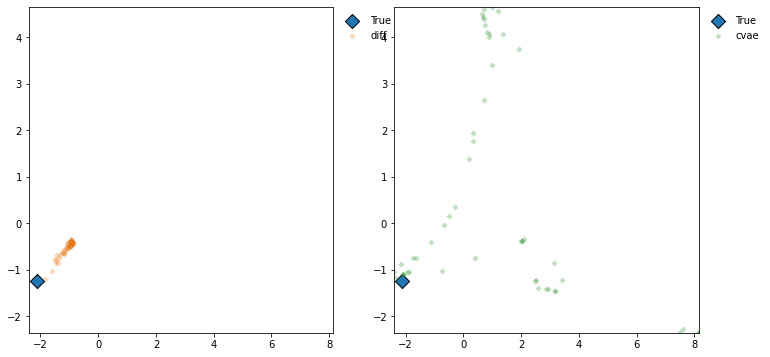


MMD diff: 4.286636829376221
WSD diff: 0.5812338816528988

MMD cvae: 4.276180267333984
WSD cvae: 1.7919666526614986


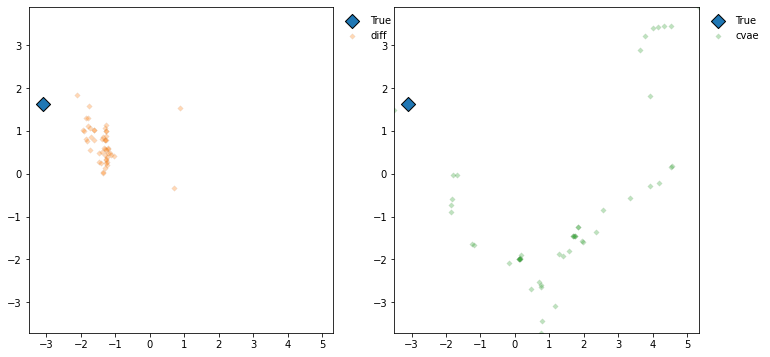


MMD diff: 4.788666248321533
WSD diff: 1.5817458065246424

MMD cvae: 1.5167531967163086
WSD cvae: 0.3613709311842961


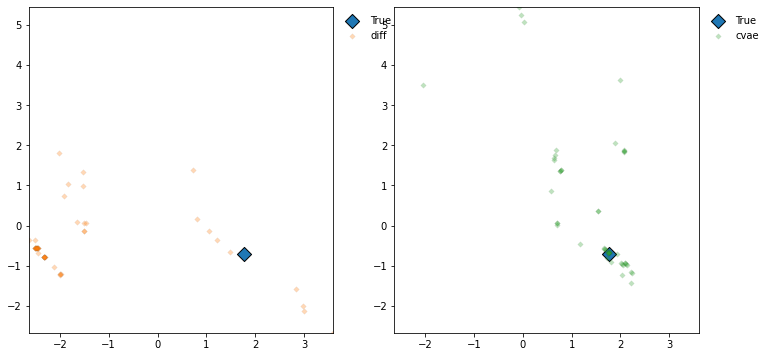


MMD diff: 2.7903003692626958
WSD diff: 0.261952882816663

MMD cvae: 2.575035095214844
WSD cvae: 0.5380443703506215


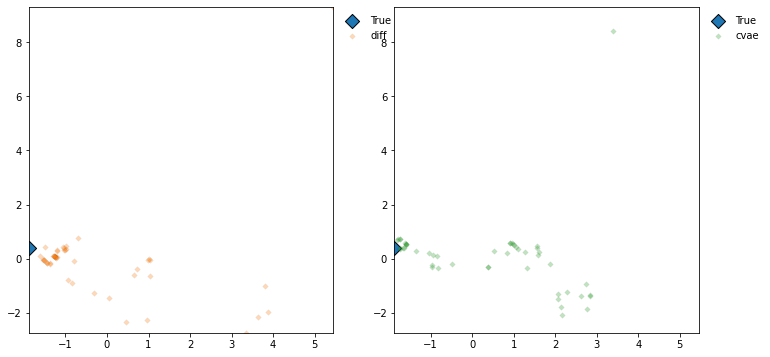


MMD diff: 3.6603407859802246
WSD diff: 0.4535421580683073

MMD cvae: 3.0124101638793945
WSD cvae: 0.3858375663576835


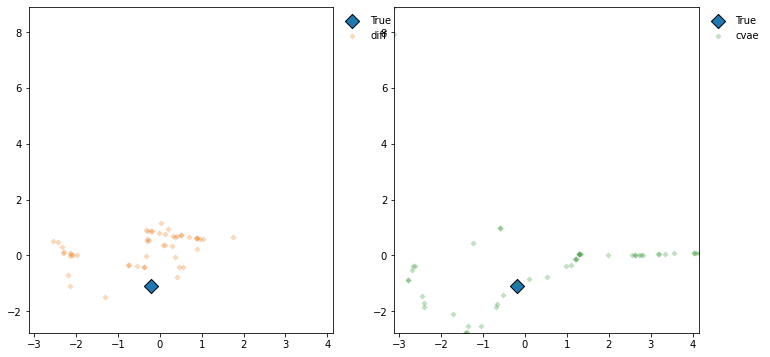


MMD diff: 1.7136459350585938
WSD diff: 0.1404332474224974

MMD cvae: 4.206203460693359
WSD cvae: 0.8362747309291665


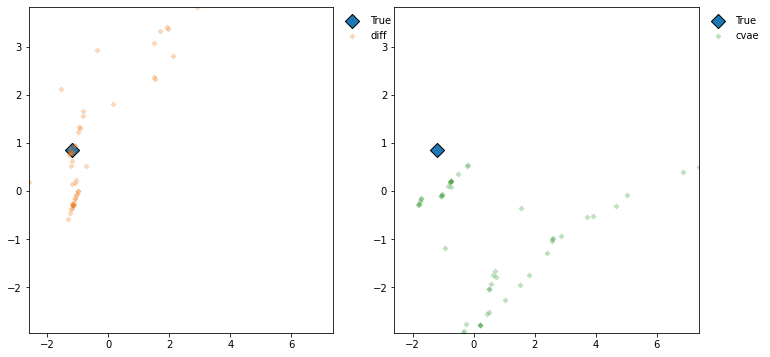


MMD diff: 5.271035194396973
WSD diff: 1.0200608470898755

MMD cvae: 4.163846492767334
WSD cvae: 0.8460145851519485


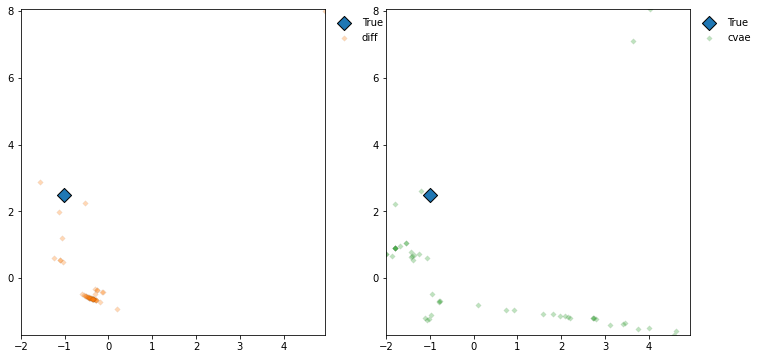


MMD diff: 0.5793256759643555
WSD diff: 0.0008707291310214

MMD cvae: 1.7241458892822266
WSD cvae: 0.443067338061366


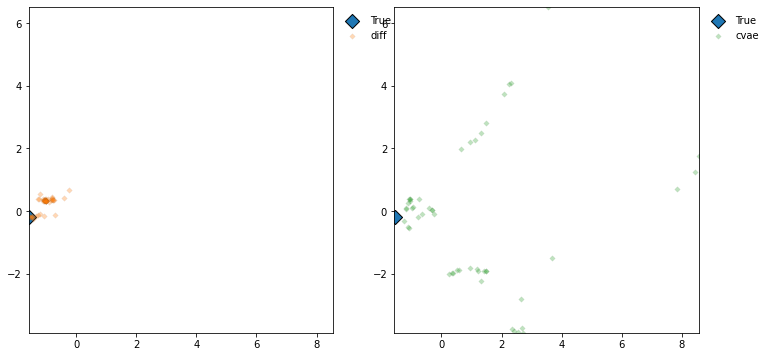


MMD diff: 5.523704051971436
WSD diff: 1.6224079189680058

MMD cvae: 3.734663486480713
WSD cvae: 1.3530535057102149


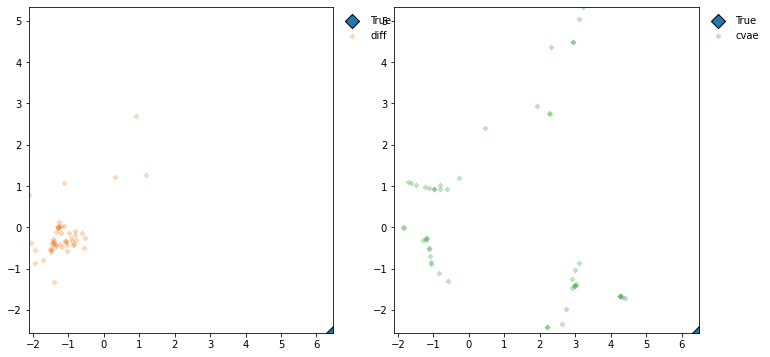


MMD diff: 2.752740859985352
WSD diff: 0.020557715542527

MMD cvae: 2.57289981842041
WSD cvae: 0.0727826937343306


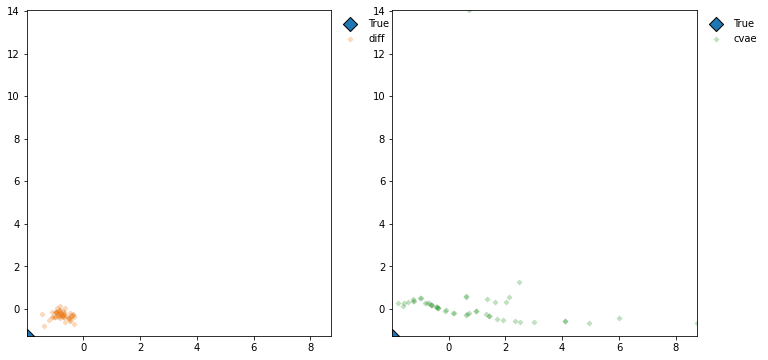


MMD diff: 0.9198827743530272
WSD diff: 0.0056514071196737

MMD cvae: 1.2285470962524414
WSD cvae: 0.0116471976364634


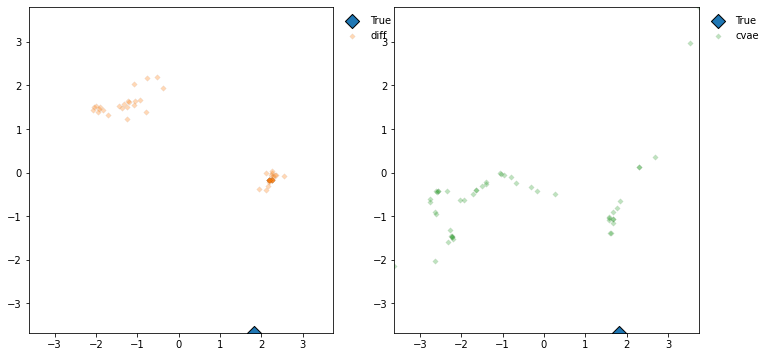


MMD diff: 1.191971778869629
WSD diff: 0.0016594712604205

MMD cvae: 1.7830381393432615
WSD cvae: 0.1385228521773669


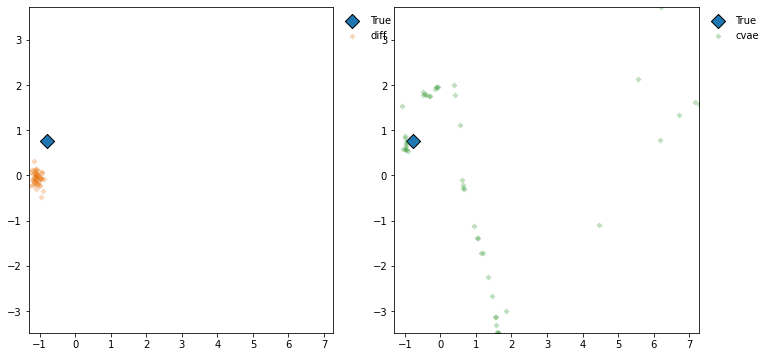


MMD diff: 2.3208608627319336
WSD diff: 0.0356471055008642

MMD cvae: 3.746396541595459
WSD cvae: 0.6845212337545108


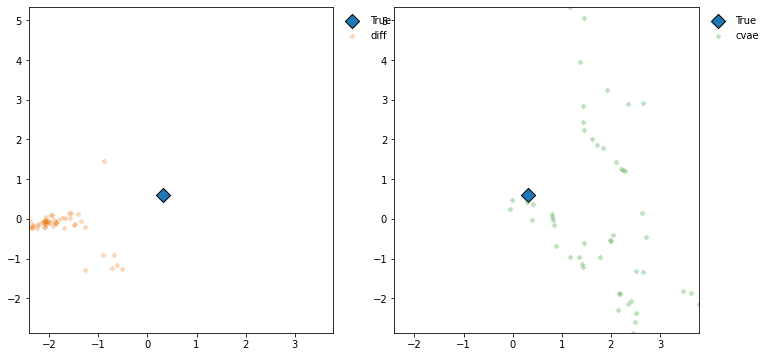


MMD diff: 2.742264747619629
WSD diff: 0.1519352139633707

MMD cvae: 2.2100934982299805
WSD cvae: 0.4611047306429287


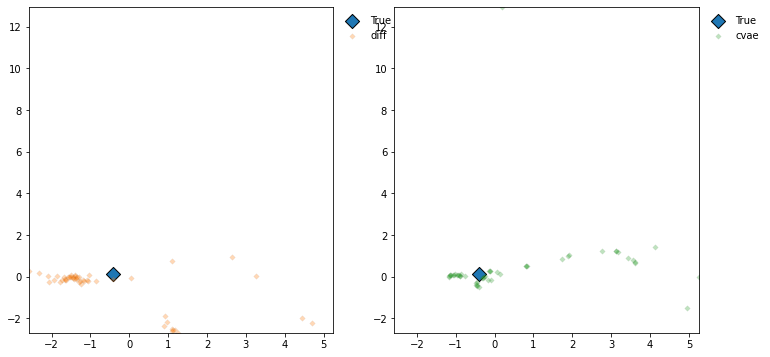


MMD diff: 6.025367736816406
WSD diff: 2.3398719459257387

MMD cvae: 4.6491217613220215
WSD cvae: 1.648161495384983


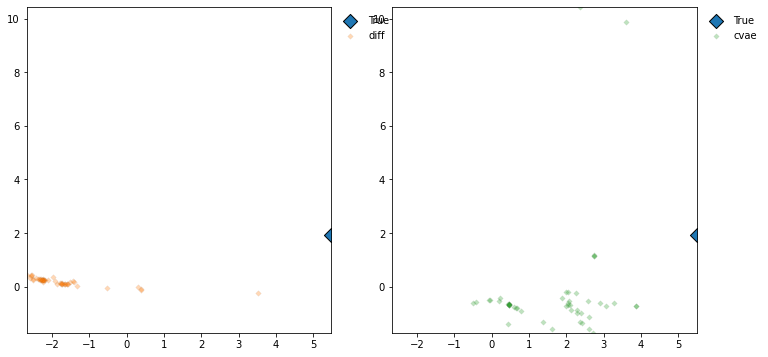


MMD diff: 2.7766218185424805
WSD diff: 0.5727142684014641

MMD cvae: 3.721280574798584
WSD cvae: 0.6196845936885589


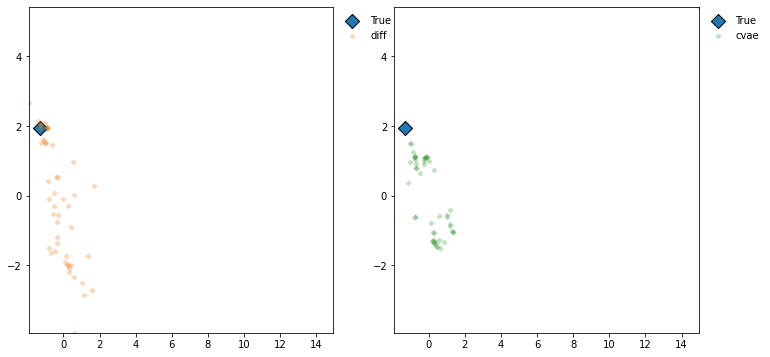


MMD diff: 0.1360921859741211
WSD diff: 0.0119361059864866

MMD cvae: 3.5311508178710938
WSD cvae: 1.031531736488941


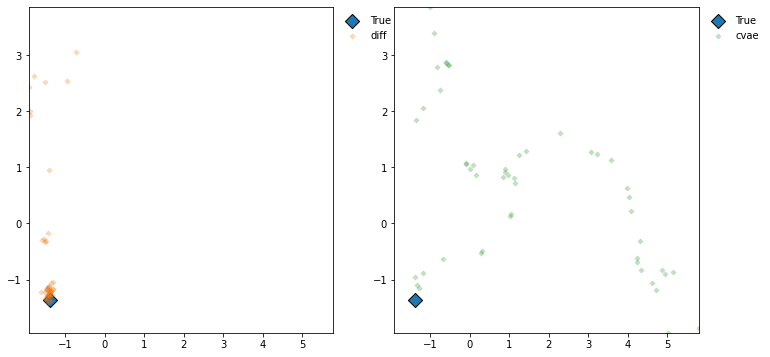

In [7]:
count = 0
for _, row in mmd_zeo_osda_df_cvae[::-1][['zeo', 'osda']].iterrows():
    zeo, osda = row['zeo'], row['osda']
    try:
        compare_side_by_side(syn_pred_diff, syn_pred_scaled_diff, syn_pred_cvae, syn_pred_scaled_cvae, syn_true_diff, syn_true_scaled_diff, dataset, mmd_zeo_agg_df_diff, wsd_zeo_agg_df_diff, mmd_zeo_osda_df_diff, wsd_zeo_osda_df_diff, mmd_zeo_agg_df_cvae, wsd_zeo_agg_df_cvae, mmd_zeo_osda_df_cvae, wsd_zeo_osda_df_cvae, zeo=zeo, osda=osda, plot=False, pca=True)
    except Exception as e:
        print(e)

    count += 1
    if count == 30:
        break